# Recreating the hertz solution numerically
***
In this note book we will cover how to use slippy to recreate the hertz solution for curved surfaces using the numerical solver in the contact sub package. In doing this the following topics will be covered:

- Generating analytical surfaces
- Making simple elastic materials
- Creating and solving a single step contact model
- Creating a static normal load step
- Analytical hertz solutions with hertz_full
***
The workflow used here is applicable to a wide range of problems, we will explore some of these at the end of this note book.

## Making the surfaces
The first step towards making a contact simulation is making the surface geometry, here we will make two surfaces one flat and one round. 

For a contact model at least the first surface must be descretised (represented by a set of points). In this example the round surface is descretised while the flat surface is represented analytically

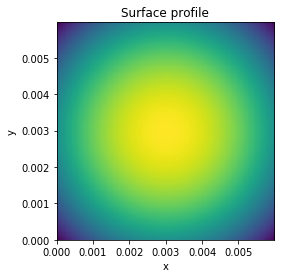

In [1]:
import slippy.surface as S
import numpy as np
%matplotlib inline

flat_surface = S.FlatSurface(shift=(0,0))
round_surface = S.RoundSurface((1,1,1), extent = (0.006, 0.006), 
                               shape = (255, 255), generate = True)
round_surface.show()

## Setting the materials
The next step is to set the materials of the surfaces, to start we will set them both to elastic materials. To do this the materials must be made then assigned to the surface as follows. The name of the material is just used to keep track of the materials which have been defined, it dosn't need to match the variable name.

In [2]:
import slippy.contact as C
steel = C.Elastic('Steel', {'E': 200e9, 'v':0.3})
aluminum = C.Elastic('Aluminum', {'E': 70e9, 'v':0.33})
flat_surface.material = aluminum
round_surface.material = steel

## Creating a contact model
Now our surfaces are set up we can create a contact model object to keep track of everything. This object just contains the informaiton needed to solve a model, it also coordinates the running of the steps for a multi step model.

In [3]:
my_model = C.ContactModel('model-1', round_surface, flat_surface)

## Adding a step to the model
Now we have a model but we have not asked it to do anything. The next step is to make a step object that contains the instructions of what you want to happen to these surfaces.

We will use a StaticNormalLoad step we will not define any tangential behaviour as there is no friction in the hertz solution.

In [4]:
total_load = 100
my_step = C.StaticStep('contact', normal_load=total_load, rtol_interference=1e-2)
my_model.add_step(my_step)
my_model.steps

OrderedDict([('Initial', InitialStep(model = None, name = initial)),
             ('contact',
              StaticStep(contact, time_period=1.0,off_set_x=0.0, off_set_y=0.0,normal_load=100, interference=Nonerelative_loading:=False, adhesion=True,unloading=False, profile_interpolation_mode=nearest,periodic_geometry=False, periodic_axes(False, False),max_it_interference=100, rtol_interference:0.01,max_it_displacement=None, rtol_displacement=0.0001))])

## Data checking the model
Before running a model it is a good idea to data check it. This check will ensure that the model is made correctly and should reduce the number of errors that will occur when running. This will likely save you a lot of development time and fustration.

In [5]:
my_model.data_check()

Data check started at:
12:36:59 01-11-2020
Checking step: Initial
Checking step: contact


## Solving the model
For a single step model like this the easiest way to solve it is to request that the output is returned, for multi step models it is preferable to write the required outputs to a file to reduce the amount of memory that is needed to run the model.

By deafult the model will write it's progress to a log file with the same name as you gave the model. This can be found in the working directory.

In [6]:
out = my_model.solve(skip_data_check = True)
print("Model completed")

Model completed


## Checking the model
Now we have found the solution lets check that it lines up with the analytical solution. Firstly, we should check that specified load was achived. There may be error in this value as it is optimised for (the interferance betweenthe surfaces is set and the load is found iteratively)

In [7]:
print(f'Load set at: {total_load}')
print(f"Loads converged at: {sum(out['loads'].z.flatten()*round_surface.grid_spacing**2)}")

Load set at: 100
Loads converged at: 100.17826792290867


So there is a very small amount of error which is acceptabel for this application. To change the amount of error present the reltaive error can be set when the step is defined. This is done by chanig the rtol_load_loop parameter.

### Now lets check that the maximum pressure and the contact area is the same as the analytical result:

In [8]:
# find the analytical result using the hertz_full function
a_result = C.hertz_full([1,1], [np.inf, np.inf], [200e9, 70e9], [0.3, 0.33], 100)
#                        r1     r2                 E1     E2     v1    v2    load

print('Analytical max pressure: ', a_result['max_pressure'])
print('Numerical max pressure: ', max(out['loads'].z.flatten()))

print('Analytical contact area: ', a_result['contact_area'])
print('Numerical contact area: ', round_surface.grid_spacing**2*sum(out['contact_nodes'].flatten()))

print('Analytical total deflection', a_result['total_deflection'])
print('Numerical total deflection', out['interference'])

Analytical max pressure:  40167183.96434862
Numerical max pressure:  40187372.96022418
Analytical contact area:  3.7343917396135165e-06
Numerical contact area:  3.771349480968859e-06
Analytical total deflection 1.1886938096020666e-06
Numerical total deflection 1.1899313717019938e-06


Again the results are very similar, the diference between the analytical and numerical results can be reduced by decreasing the tolerance on the displacement loop, the tolerance used to find the surface loads or the grid size of the surfaces or by increasing the span of the influence matrix.

### Now let's check that the pressure distribution is quadratic:

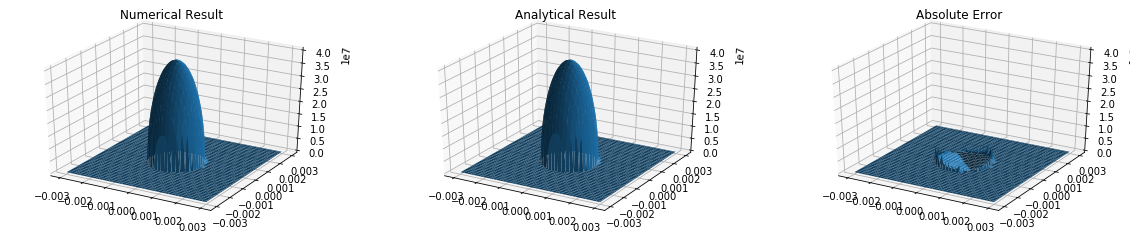

In [9]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(20, 4))
X,Y = round_surface.get_points_from_extent()
X,Y = X-X[-1,-1]/2 , Y-Y[-1,-1]/2
Z_n = out['loads'].z
ax_0 = fig.add_subplot(131, projection='3d')
ax_0.plot_surface(X, Y, Z_n, linewidth=0)
ax_0.set_title('Numerical Result')

R = np.sqrt(X**2+Y**2)
Z_a = a_result['pressure_f'](R)
ax_1 = fig.add_subplot(132, projection='3d')
ax_1.plot_surface(X, Y, Z_a, linewidth=0, facecolor = [1,0,0])
ax_1.set_title('Analytical Result')

ax_2 = fig.add_subplot(133, projection='3d')
ax_2.plot_surface(X, Y, np.abs(Z_a-Z_n), linewidth=0, facecolor = [1,0,0])
ax_2.set_zlim((0,4e7))
_ = ax_2.set_title('Absolute Error')

The results which have been returned by an analysis can be shown as follows:

In [10]:
for key in out:
    print(key)

just_touching_gap
surface_1_points
surface_2_points
time
time_step
new_step
off_set
loads
total_displacement
surface_1_displacement
surface_2_displacement
contact_nodes
total_normal_load
interference
converged
gap


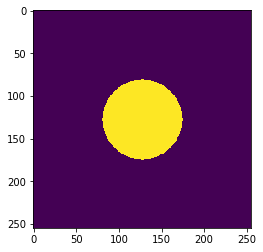

In [11]:
plt.imshow(out['contact_nodes'])

# General rough surface contact
The exact work flow defined above can be used for any rough surfce contact. As this is a live notebook the user is invited to add the following to the end of the first code block. First we will make a new random surface with a roughness of 1 micron, then we will add this to the round surface. 

In [12]:
"""
# First we define the autocorelation function of the surface
my_acf = S.ACF('exp', round_surface.grid_spacing, 1e-6, 100, 100) 
#              ^exponential                       ^1 micron roughness
# Then we will use this to generate a random surface by the linear transformation method:
random_surface = S.RandomSurface(my_acf, grid_spacing=round_surface.grid_spacing, 
                                 extent = round_surface.extent, generate=True)
# Next we simply add the surfaces together and the rest of the code
round_surface = round_surface + random_surface
round_surface.show()
"""

"\n# First we define the autocorelation function of the surface\nmy_acf = S.ACF('exp', round_surface.grid_spacing, 1e-6, 100, 100) \n#              ^exponential                       ^1 micron roughness\n# Then we will use this to generate a random surface by the linear transformation method:\nrandom_surface = S.RandomSurface(my_acf, grid_spacing=round_surface.grid_spacing, \n                                 extent = round_surface.extent, generate=True)\n# Next we simply add the surfaces together and the rest of the code\nround_surface = round_surface + random_surface\nround_surface.show()\n"

## More complex analyses
More complicated analyses will require multiple steps and output requests to reduce memory requirements.